# Экстраполяция временных рядов
### Многопараметрическая экстраполяция

Под множественными регрессионными моделями будем понимать класс моделей, в которых значения одного или множества исследуемых параметров зависят **от нескольких (более одного) других параметров**.

In [ ]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Системы велошеринга - это способ проката велосипедов, при котором процесс получения членства, проката и возврата велосипедов автоматизирован с помощью сети киосков по всему городу. Используя эти системы, люди могут арендовать велосипед в одном месте и возвращать его в другое место по мере необходимости.

Данные, генерируемые этими системами, делают их привлекательными для исследователей, поскольку в них четко фиксируется продолжительность поездки, место отправления, место прибытия и затраченное время. [В этом конкурсе](https://www.kaggle.com/competitions/bike-sharing-demand/data) участникам предлагается объединить исторические данные об использовании велосипедов с данными о погоде, чтобы спрогнозировать спрос на прокат велосипедов в рамках программы Capital Bikeshare в Вашингтоне, округ Колумбия.


**Описание признаков:**

*datetime* - hourly date + timestamp  

*season* -  1 = spring, 2 = summer, 3 = fall, 4 = winter

*holiday* - whether the day is considered a holiday

*workingday* - whether the day is neither a weekend nor holiday

*weather* - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

*temp* - temperature in Celsius

*atemp* - "feels like" temperature in Celsius

*humidity* - relative humidity

*windspeed* - wind speed

*casual* - number of non-registered user rentals initiated

*registered* - number of registered user rentals initiated

*count* - number of total rentals

In [ ]:
# спрос на велошеринг (работа с временными рядами, может быть решена задача прогнозирования)
df = pd.read_csv('/content/bikes.csv', sep=',')
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


По условиям работы, мы выберем 100 значений для прогнозирования.

Добавление значений целевого параметра со сдвигом на один шаг в прошлое при построении регрессии называется созданием лагов (lags) для целевой переменной. Это позволяет учесть зависимость текущего значения целевой переменной от ее предыдущих значений.

# 3.1 Использовать не менее 2-х параметров для прогнозирования целевого параметра

In [ ]:
n1 = 101
n2 = 300

df['lag'] = df['count'].iloc[n1-1:n2].shift(1).copy()
df = df[n1:n2].copy().reset_index(drop=True)

# сделаем колонку "hours", дату переведём в дни
df['datetime'] = df['datetime'].astype('datetime64[ns]')
df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d")
df['hours'] = (df['datetime'] - df['datetime'].iloc[0]).dt.total_seconds() / (60*60)
df['hours'] -= df['hours'].iloc[0] - 1

# признаки и таргет
X = df[['atemp', 'humidity', 'windspeed', 'hours']]
y = df['count']
X.head()

,atemp,humidity,windspeed,hours
0,9.850,37,22.0028,1.0
1,11.365,33,22.0028,2.0
2,11.365,33,22.0028,3.0
3,12.880,30,19.9995,4.0
4,14.395,28,12.9980,5.0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Метод наименьших квадратов

Используем МНК для многопараметрической регрессии

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(np.array(X_train), np.array(y_train))
res_mnk = model.predict(np.array(X_test))

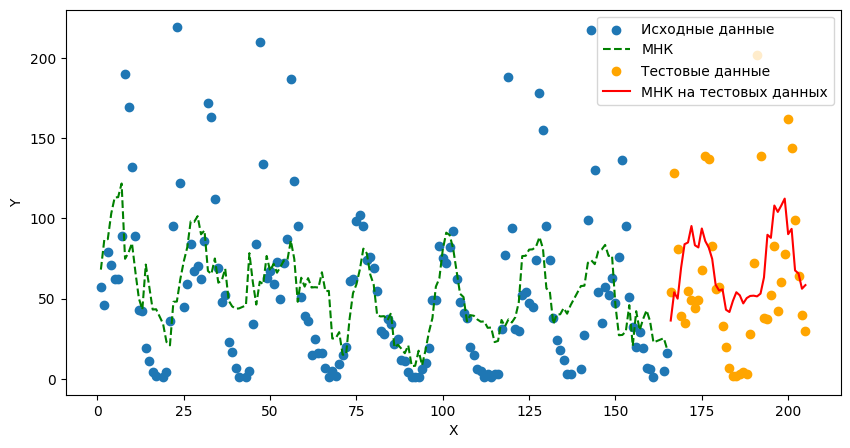

In [ ]:
# визуализируем данные и регрессионную линию
plt.figure(figsize=(10, 5))
plt.scatter(X_train['hours'], y_train, label='Исходные данные')
plt.plot(X_train['hours'], model.predict(np.array(X_train)), color='green', label='МНК', ls='dashed')
plt.scatter(X_test['hours'], y_test, color='orange', label='Тестовые данные')
plt.plot(X_test['hours'], res_mnk, color='red', label='МНК на тестовых данных')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### SVM

In [ ]:
from sklearn.svm import SVR

# модель SVM для регрессии
model = SVR(kernel='linear', C=1.0)

res_svm = model.fit(X_train, y_train).predict(X_test)

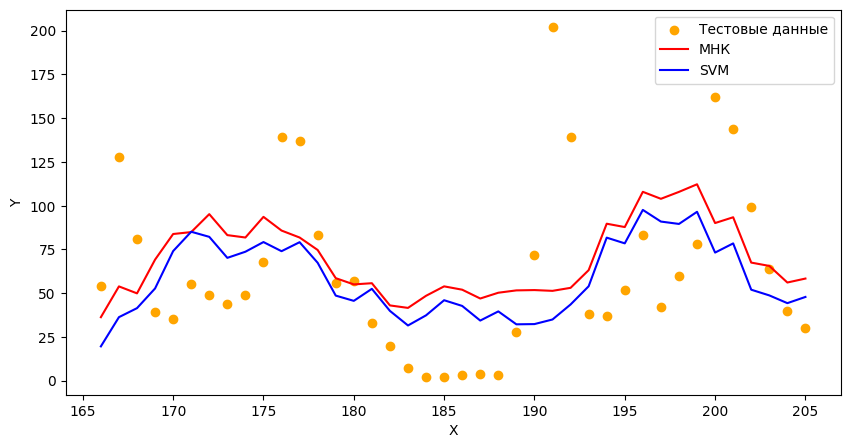

In [ ]:
# визуализация данных и регрессии
plt.figure(figsize=(10, 5))
#для сравнения, добавим данные, полученные в предыдущем примере
# plt.scatter(X_train['hours'], y_train, label='Исходные данные')
# plt.plot(X_train['hours'], model.predict(np.array(X_train)), color='green', label='МНК', ls='dashed')
plt.scatter(X_test['hours'], y_test, color='orange', label='Тестовые данные')
plt.plot(X_test['hours'], res_mnk, color='red', label='МНК')
plt.plot(X_test['hours'], res_svm, color='blue', label='SVM')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### kNN

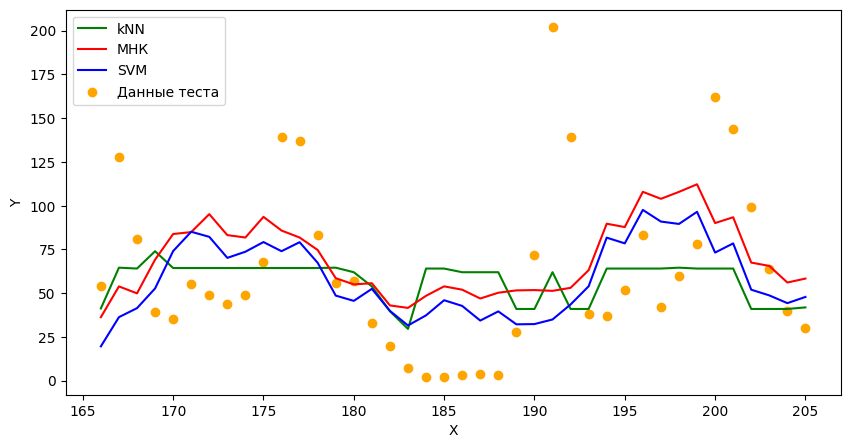

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

k = 10
model = KNeighborsRegressor(n_neighbors=k)
model.fit(X_train, y_train)
res_knn = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(X_test['hours'], res_knn, color='green', label='kNN')
plt.plot(X_test['hours'], res_mnk, color='red', label='МНК')
plt.plot(X_test['hours'], res_svm, color='blue', label='SVM')
plt.scatter(X_test['hours'], y_test, color='orange', label='Данные теста')
#plt.scatter(X_train['hours'], y_train, label='Данные тренировки')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### Lasso (Least absolute shrinkage and selection operator)

 Регрессия по методу наименьших квадратов (МНК) часто может стать неустойчивой, то есть сильно зависящей от обучающих данных, что обычно является проявлением тенденции к переобучению. Избежать такого переобучения помогает регуляризация - общий метод, заключающийся в наложении дополнительных ограничений на искомые параметры, которые могут предотвратить излишнюю сложность модели. Смысл процедуры заключается в “стягивании” в ходе настройки вектора коэффициентов  β  таким образом, чтобы они в среднем оказались несколько меньше по абсолютной величине, чем это было бы при оптимизации по МНК.

 Метод регрессии “лассо” (LASSO, Least Absolute Shrinkage and Selection Operator) заключается во введении дополнительного слагаемого регуляризации в функционал оптимизации модели, что часто позволяет получать более устойчивое решение. Условие минимизации квадратов ошибки при оценке параметров  $\hat{\beta}$
  выражается следующей формулой:

$\hat{\beta} = argmin(\sum_{i}^n(y_i-\sum_{j}^m \beta x_{ij})^2 + \lambda |\beta|)$,
где  λ  - параметр регуляризации, имеющий смысл штрафа за сложность.

λ = 0, метод ЛАССО сводится к МНК, а при увеличении $\lambda$ формируемая модель становится все более “лаконичной”, пока не превратится в нуль-модель.

Метод Лассо также иногда называют  L1-регуляризацией.

Оптимальная $\lambda$ находится с использованием кросс-валидации (т.е. такая $\lambda$, которой соответствует наименьшая ошибка прогноза)


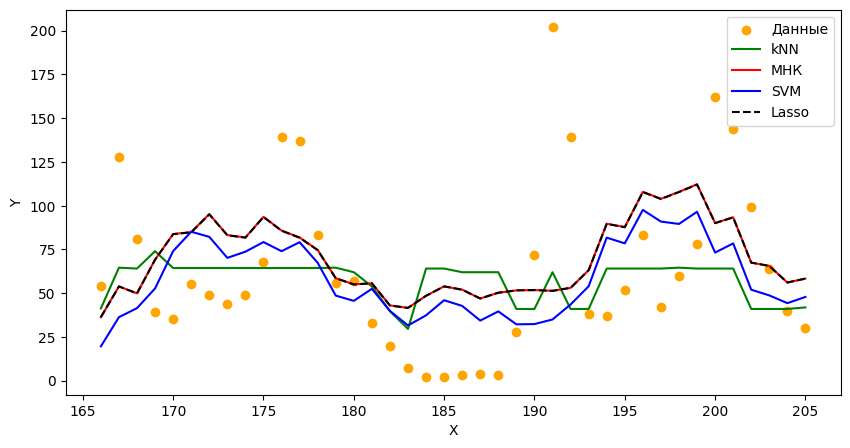

In [ ]:
from sklearn.linear_model import Lasso

alpha = 0.05
model = Lasso(alpha=alpha)
model.fit(X_train, y_train)
res_lasso = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.scatter(X_test['hours'], y_test, label='Данные', color="orange")
plt.plot(X_test['hours'], res_knn, color='green', label='kNN')
plt.plot(X_test['hours'], res_mnk, color='red', label='МНК')
plt.plot(X_test['hours'], res_svm, color='blue', label='SVM')
plt.plot(X_test['hours'], res_lasso, color="black", label='Lasso', ls='dashed')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### Метод частных наименьших квадратов (PLS)

Основная цель PLS - это уменьшить размерность набора данных, проектируя исходные признаки на некоторое меньшее число новых признаков (компонентов), которые линейно связаны с зависимой переменной. Это помогает улучшить способность модели к предсказанию, особенно в случаях, когда исходный набор признаков мультиколлинеарен (сильно коррелируют между собой) или имеет много шумовых переменных.

Общая базовая модель многомерного PLS:

$X=TP^T+E$
$Y=UQ^T+F$

где $X$ - матрица предикторов $m*n$, $Y$ - матрица ответов $n*p$; $T$ и $U$ - это матрицы $n*l$, которые являются, соответственно, проекциями $X$ (оценка X, матрица компонентов или факторов) и проекциями Y (Y баллы); $P$ и $Q$,соответственно $m*l$ и $ p*l$ , и ортогональная загрузка. матрицы; а матрицы $E$ и $F$ - это члены ошибок, которые считаются независимыми и одинаково распределенными случайными нормальными величинами. Разложение $X$ и $Y$ производится таким образом, чтобы максимизировать ковариацию между $T$ и $U$.

(Источник https://wiki5.ru/wiki/Partial_least_squares_regression)



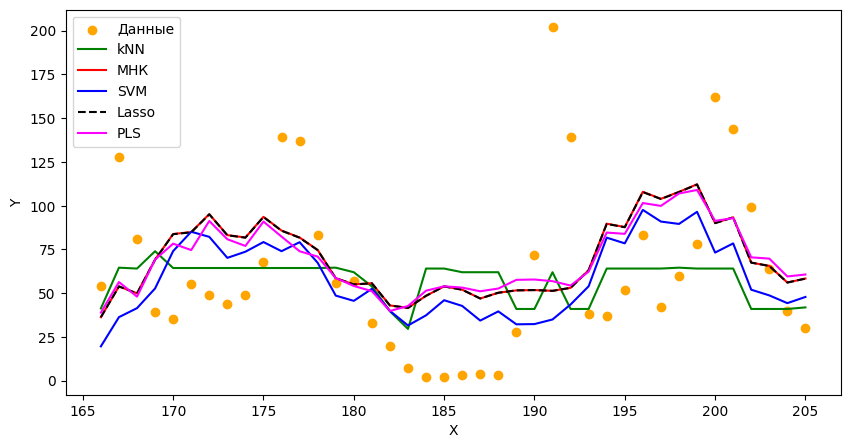

In [ ]:
from sklearn.cross_decomposition import PLSRegression

n_components = 3
model = PLSRegression(n_components=n_components)
model.fit(X_train, y_train)
res_pls = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.scatter(X_test['hours'], y_test, color="orange", label='Данные')
plt.plot(X_test['hours'], res_knn, color='green', label='kNN')
plt.plot(X_test['hours'], res_mnk, color='red', label='МНК')
plt.plot(X_test['hours'], res_svm, color='blue', label='SVM')
plt.plot(X_test['hours'], res_lasso, color="black", label='Lasso', ls='dashed')
plt.plot(X_test['hours'], res_pls, color="magenta", label='PLS')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# 3.2. Добавить к параметрам из варианта 3.1 значения целевого параметра со сдвигом на один шаг в прошлое

In [ ]:
# признаки и таргет
X = df[['atemp', 'humidity', 'windspeed', 'lag', 'hours']]
y = df['count']
X.head()

,atemp,humidity,windspeed,lag,hours
0,9.850,37,22.0028,115.0,1.0
1,11.365,33,22.0028,57.0,2.0
2,11.365,33,22.0028,46.0,3.0
3,12.880,30,19.9995,79.0,4.0
4,14.395,28,12.9980,71.0,5.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### Метод наименьших квадратов

Используем МНК для многопараметрической регрессии

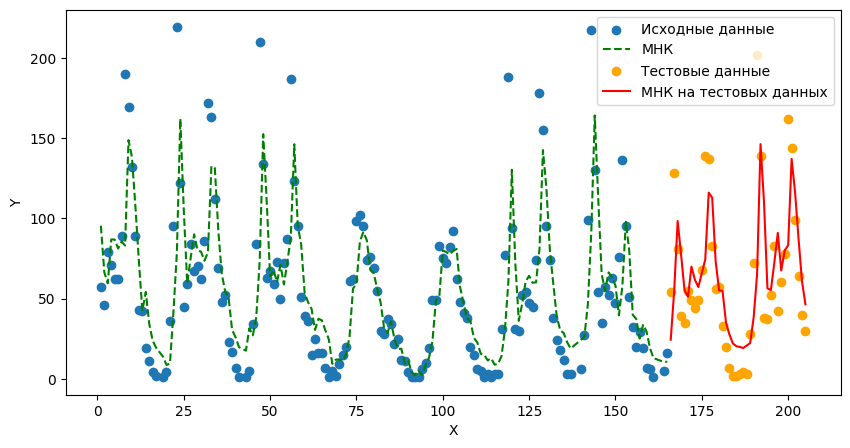

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(np.array(X_train), np.array(y_train))
res_mnk = model.predict(np.array(X_test))

# визуализируем данные и регрессионную линию
plt.figure(figsize=(10, 5))
plt.scatter(X_train['hours'], y_train, label='Исходные данные')
plt.plot(X_train['hours'], model.predict(np.array(X_train)), color='green', label='МНК', ls='dashed')
plt.scatter(X_test['hours'], y_test, color='orange', label='Тестовые данные')
plt.plot(X_test['hours'], res_mnk, color='red', label='МНК на тестовых данных')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### SVM

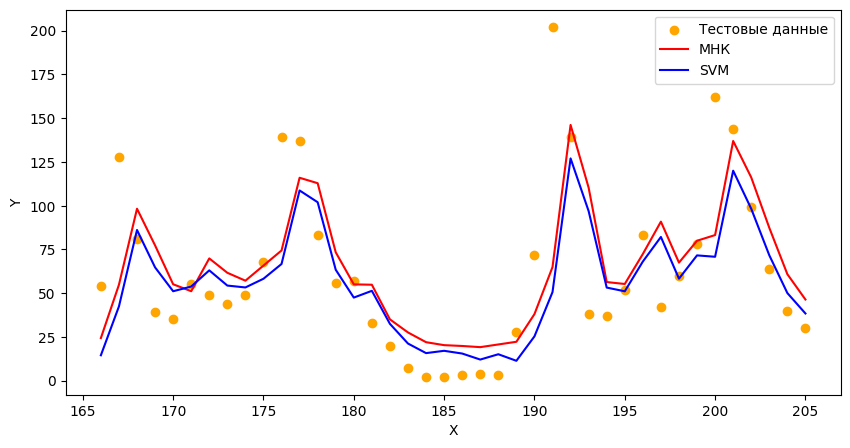

In [ ]:
from sklearn.svm import SVR

# модель SVM для регрессии
model = SVR(kernel='linear', C=1.0)
res_svm = model.fit(X_train, y_train).predict(X_test)

# визуализация данных и регрессии
plt.figure(figsize=(10, 5))
#для сравнения, добавим данные, полученные в предыдущем примере
# plt.scatter(X_train['hours'], y_train, label='Исходные данные')
# plt.plot(X_train['hours'], model.predict(np.array(X_train)), color='green', label='МНК', ls='dashed')
plt.scatter(X_test['hours'], y_test, color='orange', label='Тестовые данные')
plt.plot(X_test['hours'], res_mnk, color='red', label='МНК')
plt.plot(X_test['hours'], res_svm, color='blue', label='SVM')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### kNN

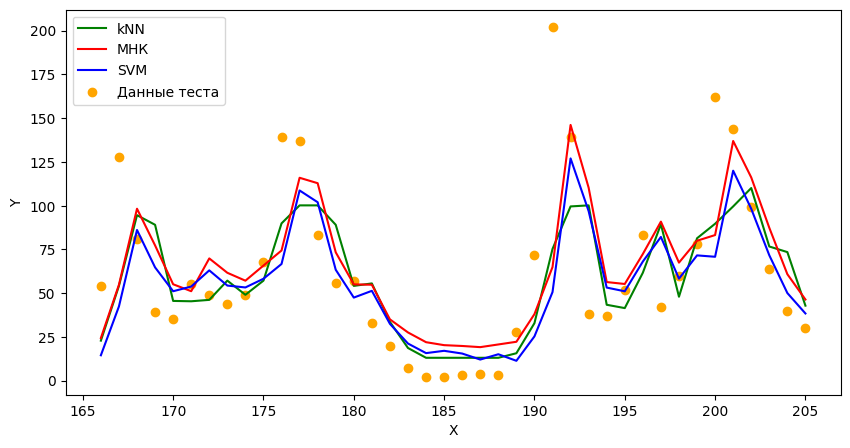

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

k = 10
model = KNeighborsRegressor(n_neighbors=k)
model.fit(X_train, y_train)
res_knn = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(X_test['hours'], res_knn, color='green', label='kNN')
plt.plot(X_test['hours'], res_mnk, color='red', label='МНК')
plt.plot(X_test['hours'], res_svm, color='blue', label='SVM')
plt.scatter(X_test['hours'], y_test, color='orange', label='Данные теста')
#plt.scatter(X_train['hours'], y_train, label='Данные тренировки')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### Lasso (Least absolute shrinkage and selection operator)

 Регрессия по методу наименьших квадратов (МНК) часто может стать неустойчивой, то есть сильно зависящей от обучающих данных, что обычно является проявлением тенденции к переобучению. Избежать такого переобучения помогает регуляризация - общий метод, заключающийся в наложении дополнительных ограничений на искомые параметры, которые могут предотвратить излишнюю сложность модели. Смысл процедуры заключается в “стягивании” в ходе настройки вектора коэффициентов  β  таким образом, чтобы они в среднем оказались несколько меньше по абсолютной величине, чем это было бы при оптимизации по МНК.

 Метод регрессии “лассо” (LASSO, Least Absolute Shrinkage and Selection Operator) заключается во введении дополнительного слагаемого регуляризации в функционал оптимизации модели, что часто позволяет получать более устойчивое решение. Условие минимизации квадратов ошибки при оценке параметров  $\hat{\beta}$
  выражается следующей формулой:

$\hat{\beta} = argmin(\sum_{i}^n(y_i-\sum_{j}^m \beta x_{ij})^2 + \lambda |\beta|)$,
где  λ  - параметр регуляризации, имеющий смысл штрафа за сложность.

λ = 0, метод ЛАССО сводится к МНК, а при увеличении $\lambda$ формируемая модель становится все более “лаконичной”, пока не превратится в нуль-модель.

Метод Лассо также иногда называют  L1-регуляризацией.

Оптимальная $\lambda$ находится с использованием кросс-валидации (т.е. такая $\lambda$, которой соответствует наименьшая ошибка прогноза)


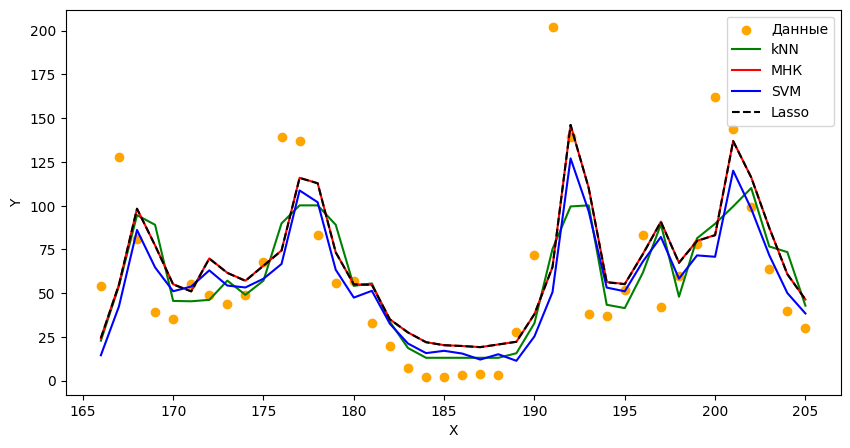

In [ ]:
from sklearn.linear_model import Lasso

alpha = 0.05
model = Lasso(alpha=alpha)
model.fit(X_train, y_train)
res_lasso = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.scatter(X_test['hours'], y_test, label='Данные', color="orange")
plt.plot(X_test['hours'], res_knn, color='green', label='kNN')
plt.plot(X_test['hours'], res_mnk, color='red', label='МНК')
plt.plot(X_test['hours'], res_svm, color='blue', label='SVM')
plt.plot(X_test['hours'], res_lasso, color="black", label='Lasso', ls='dashed')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### Метод частных наименьших квадратов (PLS)

Основная цель PLS - это уменьшить размерность набора данных, проектируя исходные признаки на некоторое меньшее число новых признаков (компонентов), которые линейно связаны с зависимой переменной. Это помогает улучшить способность модели к предсказанию, особенно в случаях, когда исходный набор признаков мультиколлинеарен (сильно коррелируют между собой) или имеет много шумовых переменных.

Общая базовая модель многомерного PLS:

$X=TP^T+E$
$Y=UQ^T+F$

где $X$ - матрица предикторов $m*n$, $Y$ - матрица ответов $n*p$; $T$ и $U$ - это матрицы $n*l$, которые являются, соответственно, проекциями $X$ (оценка X, матрица компонентов или факторов) и проекциями Y (Y баллы); $P$ и $Q$,соответственно $m*l$ и $ p*l$ , и ортогональная загрузка. матрицы; а матрицы $E$ и $F$ - это члены ошибок, которые считаются независимыми и одинаково распределенными случайными нормальными величинами. Разложение $X$ и $Y$ производится таким образом, чтобы максимизировать ковариацию между $T$ и $U$.



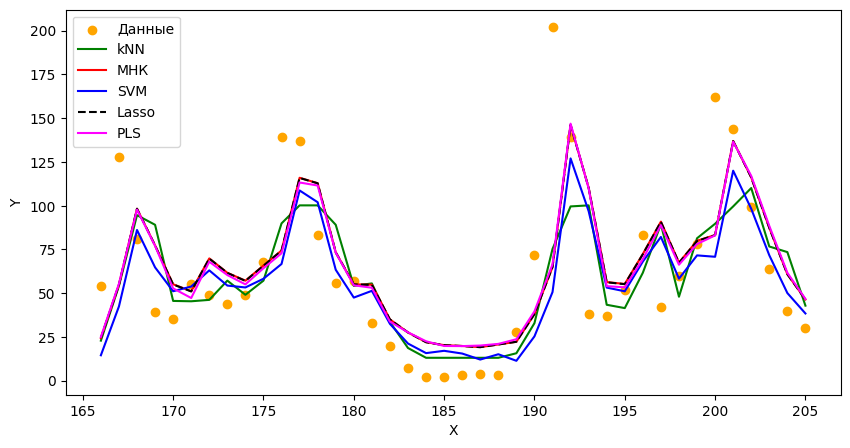

In [ ]:
from sklearn.cross_decomposition import PLSRegression

n_components = 3
model = PLSRegression(n_components=n_components)
model.fit(X_train, y_train)
res_pls = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.scatter(X_test['hours'], y_test, color="orange", label='Данные')
plt.plot(X_test['hours'], res_knn, color='green', label='kNN')
plt.plot(X_test['hours'], res_mnk, color='red', label='МНК')
plt.plot(X_test['hours'], res_svm, color='blue', label='SVM')
plt.plot(X_test['hours'], res_lasso, color="black", label='Lasso', ls='dashed')
plt.plot(X_test['hours'], res_pls, color="magenta", label='PLS')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

# Реализовать прогнозирование на заданное (N) количество шагов в будущее используя для прогнозирования каждого следующего шага (кроме первого) прогнозные значения параметров. Для прогнозирования первого значения используются реальные снятые значения

In [ ]:
N = len(X_test)-1

In [ ]:
my_predictions = [y_test.iloc[0]]

for i in range(1, N):
    last_value = np.array([[X_test['atemp'].iloc[-i], X_test['humidity'].iloc[-i], X_test['windspeed'].iloc[-i], my_predictions[-i], X_test['hours'].iloc[-i]]])
    next_prediction = model.predict(last_value)
    my_predictions.append(next_prediction[0])

In [ ]:
print("Future Predictions:", my_predictions)

Future Predictions: [54, 55.5891682249799, 56.5953083103375, 57.23231945582287, 57.63562631674409, 57.89096945354618, 58.05263324811442, 58.15498642980366, 58.21978865611467, 58.26081648217303, 58.286792171696334, 58.30323799666526, 58.31365023841407, 58.320242475558786, 58.32441617720926, 58.327058646690375, 58.32873165677671, 58.329790879132545, 58.330461497922144, 58.330886082579454, 58.331154897193684, 58.33132509010005, 58.33143284326466, 58.331501064348195, 58.331544256733835, 58.33157160285735, 58.33158891633658, 58.33159987791081, 58.33160681794338, 58.33161121184256, 58.33161399372432, 58.33161575499962, 58.331616870104774, 58.33161757610429, 58.33161802308933, 58.331618306086156, 58.331618485258154, 58.331618598696195, 58.331618670516505]


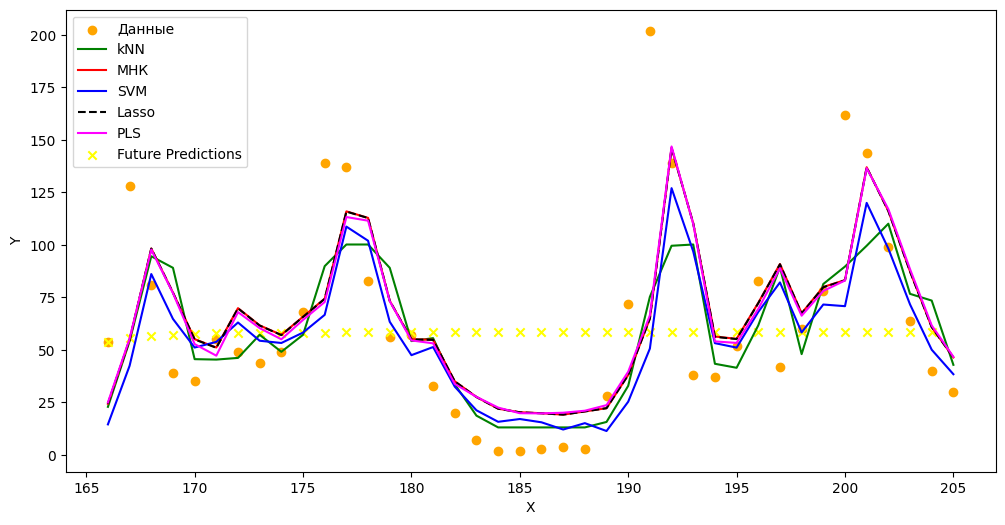

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(X_test['hours'], y_test, color="orange", label='Данные')
plt.plot(X_test['hours'], res_knn, color='green', label='kNN')
plt.plot(X_test['hours'], res_mnk, color='red', label='МНК')
plt.plot(X_test['hours'], res_svm, color='blue', label='SVM')
plt.plot(X_test['hours'], res_lasso, color="black", label='Lasso', ls='dashed')
plt.plot(X_test['hours'], res_pls, color="magenta", label='PLS')

plt.scatter(X_test['hours'][0:N], my_predictions, label='Future Predictions', color='yellow', marker='x')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()